In [1]:
#Se importan las librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from scipy.optimize import minimize
from itertools import combinations 

In [2]:
#Importamos el market data del portafolio

data = pd.read_excel("PreciosPortf.xlsx", index_col=0)
data.head()

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
DATE,,,,,
2016-01-01,243.89,94.99,177.22,43.49,72.34
2016-01-04,238.29,91.79,175.90,42.84,72.98
2016-01-05,233.03,91.72,176.45,42.66,71.48
2016-01-06,231.97,91.63,172.68,42.38,70.94
2016-01-07,230.71,89.54,172.94,39.99,72.31


In [3]:
#Generamos la matriz de rendimeinto y limpiamos los registros en donde exista un NA

rend = data.pct_change().dropna()
rend.head()

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
DATE,,,,,
2016-01-04,-0.022961,-0.033688,-0.007448,-0.014946,0.008847
2016-01-05,-0.022074,-0.000763,0.003127,-0.004202,-0.020554
2016-01-06,-0.004549,-0.000981,-0.021366,-0.006564,-0.007555
2016-01-07,-0.005432,-0.022809,0.001506,-0.056395,0.019312
2016-01-08,-0.004118,-0.007706,-0.003180,0.026007,-0.017148


In [4]:
#Generamos un base en donde solo conservemos el ticker del instrumento y generamos la matriz de rendimientos

columnas2 = []
for c in data.columns:
    columnas2.append(c.replace(" MF Equity",""))

data.columns = columnas2
rend.columns = columnas2

In [5]:
data.head(2)

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
DATE,,,,,
2016-01-01,243.89,94.99,177.22,43.49,72.34
2016-01-04,238.29,91.79,175.90,42.84,72.98


In [6]:
rend.head(2)

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
DATE,,,,,
2016-01-04,-0.022961,-0.033688,-0.007448,-0.014946,0.008847
2016-01-05,-0.022074,-0.000763,0.003127,-0.004202,-0.020554


In [7]:
#Generamos el vector de rendimiento promedio anualizado del portafolio por emisora
rend_ports = rend.mean()*252
rend_ports

ASURB       0.123539
GFNORTEO    0.078811
PE&OLES*    0.111053
WALMEX*     0.082426
IENOVA*     0.078997
dtype: float64

In [8]:
#Ahora se definen 2 funciones que servirán para el calculo del rendimiento (port_rend) y volatilidad (port_vol)

def port_rend(weights,r):
    E_p = (rend.mean() * weights).sum()*252
    return E_p

def port_vol(weights,r):
    S_p = np.sqrt(weights.T @ (r.cov()*252)@weights)
    return S_p

In [9]:
#Ahora vamos a generar portafolios simulados, para lo cual debemos generar una matriz de "Nùmero de portafolios a simular"x"Nùmero de acciones en el portafiolio"

weights_sim = np.random.random((5000,5))
weights_sim = weights_sim / weights_sim.sum(axis=1,keepdims=True)
weights_sim

array([[0.04155548, 0.34220998, 0.30086768, 0.20968686, 0.10568   ],
       [0.21367669, 0.05904187, 0.17328753, 0.28209017, 0.27190375],
       [0.3647953 , 0.05765186, 0.3972828 , 0.01246582, 0.16780421],
       ...,
       [0.1291987 , 0.00685003, 0.36555203, 0.22534068, 0.27305855],
       [0.07784214, 0.24559296, 0.26302632, 0.28615128, 0.1273873 ],
       [0.05187784, 0.27357027, 0.24880995, 0.18879115, 0.23695079]])

In [10]:
#Solo como validación, se demuestra que todos los pesos suman 1.

sum(weights_sim.sum(axis=1))

5000.0

In [11]:
rend_sim = np.apply_along_axis(port_rend,1,weights_sim,r=rend)
vol_sim = np.apply_along_axis(port_vol,1,weights_sim,r=rend)
print(rend_sim)
print(vol_sim)

[0.09114813 0.09502589 0.1080133  ... 0.09724147 0.09183149 0.08988023]
[0.1969084  0.15863532 0.20284341 ... 0.1863685  0.18130481 0.18171193]


In [12]:
#Generamos un vector que contenga el sharpe ratio para cada escenario simulado

sharpe_ratio = rend_sim / vol_sim

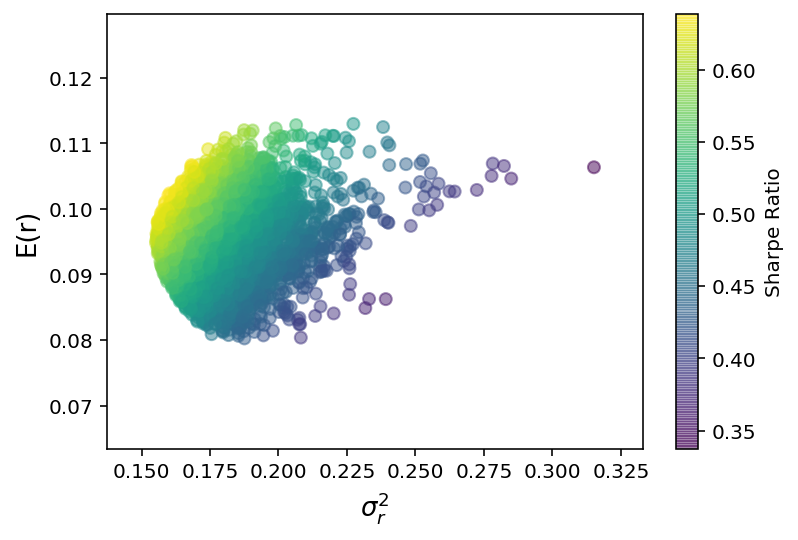

In [13]:
#Graficamos el conjunto de portafolio simulados, relacionados con su rendimiento y volatilidad
%config InlineBackend.figure_format='retina'
plt.scatter(vol_sim,rend_sim, c=sharpe_ratio,alpha=.5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [96]:
#Ahora definimos las funciones que utilizaremos para los contraints de la optimizaciòn

def sum_weights(weights):
    return weights.sum()-1

def rend_esperado(weights, E):
    return port_rend(weights, rend) - E

def allocation(weights,i,j):
    w1 = weights[i]
    w2 = weights[j]
    return -(w1+w2) + .80

def neg_weigts(weights):
    return min(weights) + .05

In [15]:
#Ahora vamos a definir un rango sobre el cual podamos genrar la frontera, tomando como lìmites los rendimeintos mínimos y máximos del portafolio inicial

rmin = rend_ports.min()
rmax = rend_ports.max()
rend_maxs = np.linspace(rmin,rmax)
rend_maxs

array([0.07881127, 0.07972409, 0.08063691, 0.08154972, 0.08246254,
       0.08337536, 0.08428817, 0.08520099, 0.0861138 , 0.08702662,
       0.08793944, 0.08885225, 0.08976507, 0.09067789, 0.0915907 ,
       0.09250352, 0.09341633, 0.09432915, 0.09524197, 0.09615478,
       0.0970676 , 0.09798041, 0.09889323, 0.09980605, 0.10071886,
       0.10163168, 0.1025445 , 0.10345731, 0.10437013, 0.10528294,
       0.10619576, 0.10710858, 0.10802139, 0.10893421, 0.10984702,
       0.11075984, 0.11167266, 0.11258547, 0.11349829, 0.11441111,
       0.11532392, 0.11623674, 0.11714955, 0.11806237, 0.11897519,
       0.119888  , 0.12080082, 0.12171364, 0.12262645, 0.12353927])

In [16]:
#Vamos a generar la frontera eficiente para un portafolio de mìnima volatilidad,obteniendo los pesos óptimos sobre todo el intervalo de rend_maxs

pesos_optimos = []
N, M = rend.shape
w_opt = np.random.randn(M)

for e in rend_maxs:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w_opt: rend_esperado(w_opt,e)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,1)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,2)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,3)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,0,4)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,1,2)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,1,3)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,1,4)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,2,3)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,2,4)},
        {"type": "ineq", "fun": lambda w_opt: allocation(w_opt,3,4)}

    ]

    
    port_opt = minimize(port_vol, w_opt,  constraints = constraints, args=rend)
    w_opt = port_opt.x
    pesos_optimos.append(w_opt)
    
pesos_optimos

[array([-0.05470766,  0.22482412,  0.02988354,  0.3893098 ,  0.4106902 ]),
 array([-0.03625861,  0.20385269,  0.03240592,  0.3911473 ,  0.4088527 ]),
 array([-0.01818983,  0.18272812,  0.03546171,  0.39292948,  0.40707052]),
 array([0.00201341, 0.16249313, 0.03549345, 0.39530415, 0.40469585]),
 array([0.01996724, 0.15233614, 0.03941539, 0.391076  , 0.39720522]),
 array([0.03826834, 0.14429939, 0.04300489, 0.38555945, 0.38886792]),
 array([0.05663384, 0.13665368, 0.04653555, 0.37977758, 0.38039935]),
 array([0.07500278, 0.12908067, 0.05006824, 0.37393596, 0.37191234]),
 array([0.09337225, 0.12152103, 0.05360169, 0.36808108, 0.36342394]),
 array([0.11174189, 0.11396379, 0.05713525, 0.3622232 , 0.35493588]),
 array([0.13011157, 0.10640689, 0.06066882, 0.35636461, 0.3464481 ]),
 array([0.14848127, 0.09884998, 0.06420239, 0.35050585, 0.33796052]),
 array([0.16685098, 0.09129296, 0.06773595, 0.34464703, 0.32947309]),
 array([0.1852207 , 0.08373582, 0.07126949, 0.33878818, 0.32098582]),
 arra

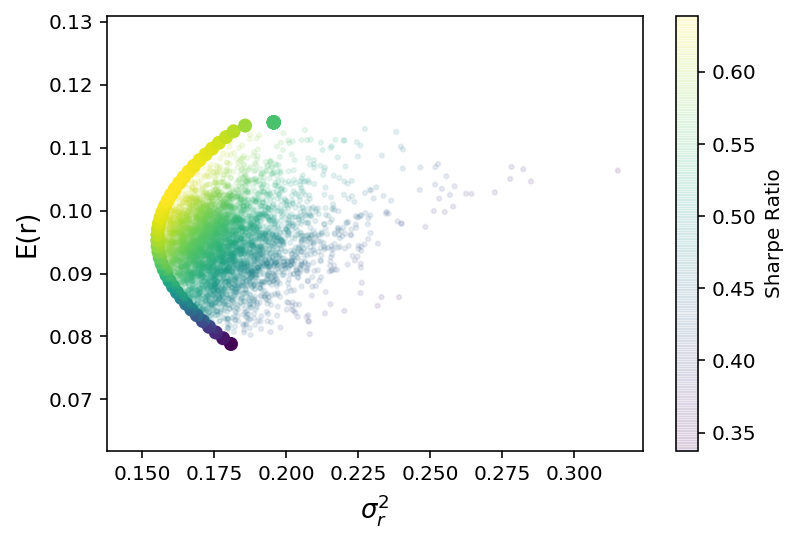

In [94]:
r_opt = []
v_opt = []

for w in pesos_optimos:
    r_opt.append(port_rend(w,rend))
    v_opt.append(port_vol(w,rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt,r_opt, c= r_opt/v_opt)
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.1, s=5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [97]:
#Ahora generamos el mismo portafolio pero garantizando que no podemos tener porcentajes negativos mayores al 5%

pesos_optimos1 = []
N, M = rend.shape
w_opt1 = np.random.randn(M)

for e in rend_maxs:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w_opt1: rend_esperado(w_opt1,e)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,0,1)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,0,2)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,0,3)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,0,4)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,1,2)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,1,3)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,1,4)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,2,3)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,2,4)},
        {"type": "ineq", "fun": lambda w_opt1: allocation(w_opt1,3,4)},
        {"type": "ineq", "fun": neg_weigts}
        

    ]

    
    port_opt1 = minimize(port_vol, w_opt1,  constraints = constraints, args=rend)
    w_opt1 = port_opt1.x
    pesos_optimos1.append(w_opt1)
    
pesos_optimos1

[array([-0.05      ,  0.22655161,  0.02344839,  0.3884111 ,  0.4115889 ]),
 array([-0.03599501,  0.2038778 ,  0.03211721,  0.39042348,  0.40957652]),
 array([-0.01812244,  0.18271318,  0.03540927,  0.39254359,  0.40745641]),
 array([0.00202209, 0.16248712, 0.03549079, 0.39521606, 0.40478394]),
 array([0.01997055, 0.15233516, 0.03941314, 0.39105407, 0.39722709]),
 array([0.03826907, 0.14429939, 0.0430045 , 0.38555371, 0.38887333]),
 array([0.05663402, 0.13665373, 0.04653547, 0.3797761 , 0.38040069]),
 array([0.07500282, 0.12908069, 0.05006823, 0.37393558, 0.37191267]),
 array([0.09337227, 0.12152104, 0.05360168, 0.36808098, 0.36342403]),
 array([0.11174189, 0.11396379, 0.05713525, 0.36222317, 0.3549359 ]),
 array([0.13011157, 0.10640689, 0.06066883, 0.35636461, 0.34644811]),
 array([0.14848127, 0.09884998, 0.06420239, 0.35050585, 0.33796052]),
 array([0.16685098, 0.09129296, 0.06773595, 0.34464703, 0.32947309]),
 array([0.18522069, 0.08373582, 0.07126949, 0.33878817, 0.32098582]),
 arra

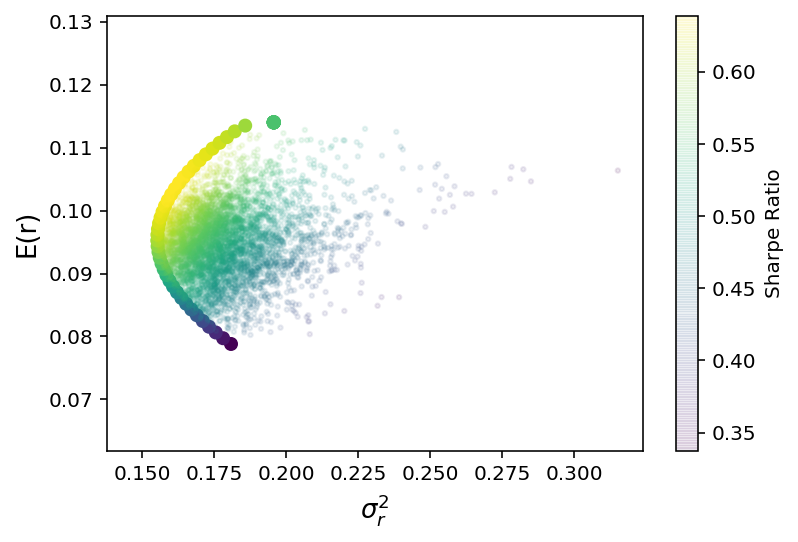

In [98]:
r_opt1 = []
v_opt1 = []

for w in pesos_optimos1:
    r_opt1.append(port_rend(w,rend))
    v_opt1.append(port_vol(w,rend))

r_opt1 = np.array(r_opt1)
v_opt1 = np.array(v_opt1)

plt.scatter(v_opt1,r_opt1, c= r_opt1/v_opt1)
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.1, s=5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

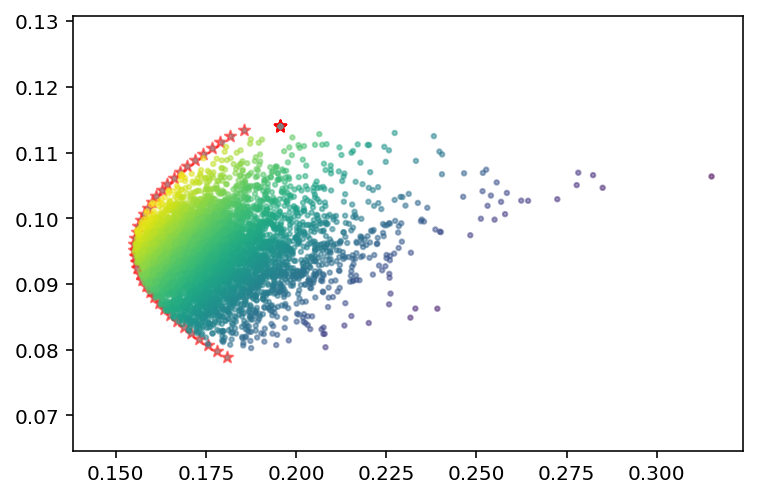

In [99]:
#Graficamos ambas fronteras
plt.scatter(v_opt,r_opt, c= "red",linewidths=1,alpha=.5,marker = "*")
plt.scatter(v_opt1,r_opt1, c= "gray",linewidths=.01,alpha=.5,marker = ".")
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.5, s=5)

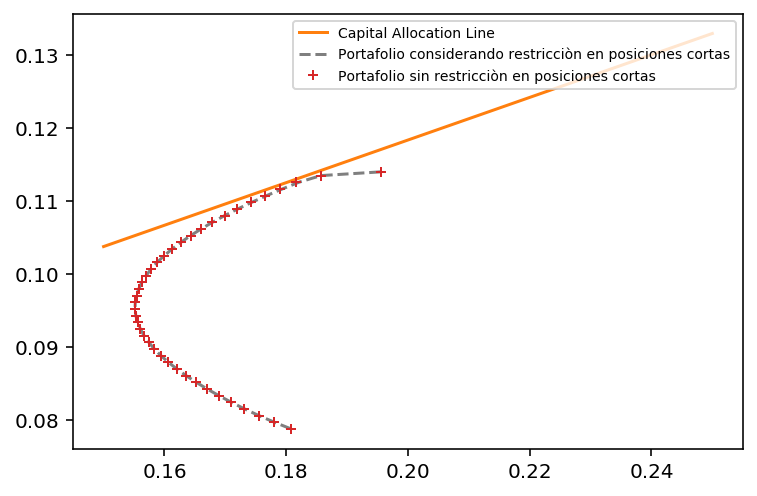

In [100]:
#Finalmente genramos la CAL junto con su gràfica, realizando el overlay con las fronteras de los 2 portafolios generados.
rf = 0.06
w0 = np.random.randn(M)

def min_func_sharpe(weights):
    return - (port_rend(weights, rend) - rf)/port_vol(weights,rend)

constraints2 = [
    {"type": "eq","fun":sum_weights}
]

f_sharpe = minimize(min_func_sharpe,w0, constraints = constraints2)
w_sharpe = f_sharpe.x
e_sharpe = port_rend(w_sharpe,rend)
vol_sharpe = port_vol(w_sharpe, rend)

sigma_c = np.linspace(.15,0.25)
sharpe = rf + sigma_c * (e_sharpe - rf) / vol_sharpe

plt.plot(sigma_c,sharpe, linestyle = "-", c= "tab:orange",label = "Capital Allocation Line")
plt.plot(v_opt1,r_opt1, linestyle = "--", c= "tab:gray",label = "Portafolio considerando restricciòn en posiciones cortas")
plt.plot(v_opt,r_opt,linestyle = "",marker="+",markersize=5.0, c= "tab:red",label = "Portafolio sin restricciòn en posiciones cortas")
plt.legend(fontsize=7, loc ='upper right' )